# QaQc Outlier Range and Analysis

Contributers: Kamran Kazemi

-------------------------------------------------------------------------------------------------------------------------------

This notebook will focus on a lot of the points that Nina Aragon raised regarding the bounds for our outliers when doing a climatolgoy comparison of `SNODAS` and `CSO` data. I will go over the statistical methods that are currently at the forefront of what we may do and than explore ways in that we can tigthen it up for our specific needs.

# Two Approaches
We currently have two approaches that we can take when searching for possible outlier points.

## IQR: $$IQR = Q3-Q1$$

A datapoint is an outlier if:
$$value < Q1 - 1.5 * IQR$$
$$value > Q3 + 1.5 * IQR$$

## z-scores: $$z = \frac{value - \mu}{\sigma}$$

A datapoint is an outlier if:
$$z < -3$$
$$z > +3$$

We will analyze both of these and see which one fits our data best and than the one that fits best will have it's thresholds tweaked to best fit our data needs.

## Problems with using z-scores

I originally used z-scores in my own explorations of how to determine outliers when comparing the data sets; however there is one big problem with doing so: our data is not normally distributed! Z-scores are primarily used for data that is normally distrbuted as it's simply a measure for how many standard deviations a value is away from the mean. In our own data; the mean does not stand as the end all be all for common or acceptable data observations so using it in this way would neglect the variance we have in our data set.

## Settling on the IQR

I think we should settle on IQR as this method is best for data in which it is not normally distributed due it's outliers being those that do not fall within the IQR; which creates bounds based upon how much data falls within the middle 50% of the data.

Some documentation of IQR: https://www.statisticshowto.com/probability-and-statistics/interquartile-range/

Some documentation for using IQR to find outliers: https://www.purplemath.com/modules/boxwhisk3.htm

Also the IQR can be easily explored visually using BoxPlots through packages such as seaborn.
The question now remains; why the 1.5 rule? Is there any benefit to changing it or is it simply the already the best possible measure for outliers? Another important question is that; how well does this work for things such as specific number bias in `CSO` such as snow probe length?

*"Remember that the interquartile rule is only a rule of thumb that generally holds but does not apply to every case. In general, you should always follow up your outlier analysis by studying the resulting outliers to see if they make sense. Any potential outlier obtained by the interquartile method should be examined in the context of the entire set of data."*

# Implementaion of the IQR outlier search
This is where I will implement the IQR method into a small chunk of our data that we can use to compare to CSO. I do not have the full data set so for the time being this will hopefully be a good window for the `SNODAS` climatology.

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

Environment file for this notebook: `enivronment_QaQc.yml`
Note: `.sjoin` method requires `pygeos` package, it is included in the environment however I experienced
some problems with it. It is also not very well documented as it works mostly internally inside of geopandas.

# Create our Dataframe

Won't be used right now, but this is from Anthony's Snodas wrapper

In [2]:
df = pd.read_pickle('/Users/kamrankazemi/Coding projects/cso_qaqc_outliers/snodas_vs_cso')
df

,longitude,latitude,date,CSO_hs,snodas_hs,difference
3318,-110.948868,43.507211,2017-10-14,0.4500,0.085,-0.3650
3317,-121.882284,44.401997,2017-10-15,0.4318,0.342,-0.0898
3316,-122.150324,46.230208,2017-10-16,0.1524,0.068,-0.0844
3311,-105.873374,39.749913,2017-10-21,0.3556,0.000,-0.3556
3313,-105.889726,39.774098,2017-10-21,0.2540,0.000,-0.2540
...,...,...,...,...,...,...
4,-121.414483,47.454700,2021-07-10,0.5000,0.000,-0.5000
3,-121.328724,47.439238,2021-07-24,0.1000,0.000,-0.1000
2,-121.341133,47.635083,2021-08-09,0.6500,0.000,-0.6500
1,-121.339810,47.636969,2021-08-09,0.6000,0.000,-0.6000


## Remove negative snodas_hs

In [3]:
df.drop(df[df['snodas_hs']<0.0].index, inplace = True)

# Pull out the snodas statistics into xarray datasets

This will be done locally with the different .tif files that Nina provided me.

Also all .tif data is currently in the form of millimeters. Our CSO data is in the form of meters.

## Q1 snodas data

From `03011036q1.tif`

In [4]:
q1 = xr.open_rasterio('/Users/kamrankazemi/Coding projects/cso_qaqc_outliers/03011036q1.tif') # The directory location of the current tif you're working with
q1 = q1.squeeze(drop = True)
q1 = xr.Dataset(data_vars={'snd': q1})
snodas_q1 = q1.where(q1['snd'] > 0)
snodas_q1 = snodas_q1.rename({'x': 'longitude','y': 'latitude'})
snodas_q1

/var/folders/w0/npl6lv_54kq3r4xbbv4gzb2c0000gn/T/ipykernel_57774/1780479362.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  q1 = xr.open_rasterio('/Users/kamrankazemi/Coding projects/cso_qaqc_outliers/03011036q1.tif') # The directory location of the current tif you're working with


<xarray.Dataset>
Dimensions:    (latitude: 3351, longitude: 6935)
Coordinates:
  * latitude   (latitude) float64 52.87 52.86 52.85 52.85 ... 24.97 24.96 24.95
  * longitude  (longitude) float64 -124.7 -124.7 -124.7 ... -66.96 -66.95 -66.95
Data variables:
    snd        (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan

In [5]:
#snodas_q1.snd.plot.hist()

## Q3 snodas data

From `03011036q3.tif`

In [6]:
q3 = xr.open_rasterio('/Users/kamrankazemi/Coding projects/cso_qaqc_outliers/03011036q3.tif') # The directory location of the current tif you're working with
q3 = q3.squeeze(drop = True)
q3 = xr.Dataset(data_vars={'snd': q3})
snodas_q3 = q3.where(q3['snd'] > 0)
snodas_q3 = snodas_q3.rename({'x': 'longitude','y': 'latitude'})
snodas_q3

/var/folders/w0/npl6lv_54kq3r4xbbv4gzb2c0000gn/T/ipykernel_57774/3945545893.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  q3 = xr.open_rasterio('/Users/kamrankazemi/Coding projects/cso_qaqc_outliers/03011036q3.tif') # The directory location of the current tif you're working with


<xarray.Dataset>
Dimensions:    (latitude: 3351, longitude: 6935)
Coordinates:
  * latitude   (latitude) float64 52.87 52.86 52.85 52.85 ... 24.97 24.96 24.95
  * longitude  (longitude) float64 -124.7 -124.7 -124.7 ... -66.96 -66.95 -66.95
Data variables:
    snd        (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan

In [7]:
#snodas_q3.snd.plot.hist()

## Creating our IQR of the snodas data

Following IQR: `Q3 - Q1`

In [8]:
iqr = snodas_q3['snd'] - snodas_q1['snd']
snodas_iqr = xr.Dataset(data_vars={'snd': iqr})
snodas_iqr

<xarray.Dataset>
Dimensions:    (latitude: 3351, longitude: 6935)
Coordinates:
  * latitude   (latitude) float64 52.87 52.86 52.85 52.85 ... 24.97 24.96 24.95
  * longitude  (longitude) float64 -124.7 -124.7 -124.7 ... -66.96 -66.95 -66.95
Data variables:
    snd        (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan

In [9]:
#snodas_iqr.snd.plot.hist()

In [10]:
#snodas_iqr.max()

## Creating our outlier bounds dataset

Following Lower: `Q1 - (1.5 * IQR)` and Upper: `Q3 + (1.5 * IQR)`

In [11]:
lwr_bnd = snodas_q1['snd'] - (1.5 * snodas_iqr['snd'])
uppr_bnd = snodas_q3['snd'] + (1.5 * snodas_iqr['snd'])
snodas_outliers = xr.Dataset(data_vars={'lwr_bnd': lwr_bnd, 'uppr_bnd': uppr_bnd})
snodas_outliers['uppr_bnd'] = snodas_outliers['uppr_bnd'].where(snodas_outliers['uppr_bnd'] > 0)
snodas_outliers['lwr_bnd'] = snodas_outliers['lwr_bnd'].where(snodas_outliers['lwr_bnd'] > 0)
snodas_outliers

<xarray.Dataset>
Dimensions:    (latitude: 3351, longitude: 6935)
Coordinates:
  * latitude   (latitude) float64 52.87 52.86 52.85 52.85 ... 24.97 24.96 24.95
  * longitude  (longitude) float64 -124.7 -124.7 -124.7 ... -66.96 -66.95 -66.95
Data variables:
    lwr_bnd    (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
    uppr_bnd   (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan

In [12]:
#snodas_outliers.lwr_bnd.plot()

In [13]:
#snodas_outliers.uppr_bnd.plot()

In [14]:
#snodas_outliers.lwr_bnd.min()

In [15]:
#snodas_outliers.uppr_bnd.max()

(array([3.297343e+06, 2.707000e+03, 2.100000e+01, 7.000000e+00,
        9.000000e+00, 8.000000e+00, 2.000000e+00, 3.000000e+00,
        3.000000e+00, 4.000000e+00]),
 array([5.600000e+01, 6.430450e+03, 1.280490e+04, 1.917935e+04,
        2.555380e+04, 3.192825e+04, 3.830270e+04, 4.467715e+04,
        5.105160e+04, 5.742605e+04, 6.380050e+04]),
 <BarContainer object of 10 artists>)

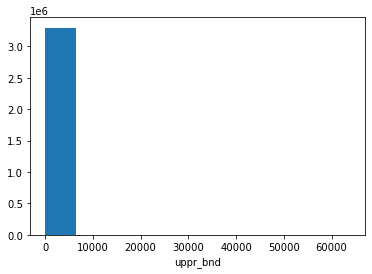

In [16]:
snodas_outliers.uppr_bnd.plot.hist()

Make a function to create the datasets from the .tifs (consistency, cleaner)

# Begin comparing CSO data to our outlier dataset to see how well it works.

This next step will involve comparing the nearest CSO value to the outlier bounds that we have created. From there we will hopefull be able to tidy up our actual bounds to best fit the CSO data.

In [17]:
snodas_outliers.assign(variable = df)

<xarray.Dataset>
Dimensions:    (latitude: 3351, longitude: 6935, dim_0: 2856, dim_1: 6)
Coordinates:
  * latitude   (latitude) float64 52.87 52.86 52.85 52.85 ... 24.97 24.96 24.95
  * longitude  (longitude) float64 -124.7 -124.7 -124.7 ... -66.96 -66.95 -66.95
  * dim_0      (dim_0) int64 3318 3317 3316 3311 3313 3312 3309 ... 5 4 3 2 1 0
  * dim_1      (dim_1) object 'longitude' 'latitude' ... 'difference'
Data variables:
    lwr_bnd    (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
    uppr_bnd   (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
    variable   (dim_0, dim_1) object -110.94886779785158 ... -1.6

In [18]:
df

,longitude,latitude,date,CSO_hs,snodas_hs,difference
3318,-110.948868,43.507211,2017-10-14,0.4500,0.085,-0.3650
3317,-121.882284,44.401997,2017-10-15,0.4318,0.342,-0.0898
3316,-122.150324,46.230208,2017-10-16,0.1524,0.068,-0.0844
3311,-105.873374,39.749913,2017-10-21,0.3556,0.000,-0.3556
3313,-105.889726,39.774098,2017-10-21,0.2540,0.000,-0.2540
...,...,...,...,...,...,...
4,-121.414483,47.454700,2021-07-10,0.5000,0.000,-0.5000
3,-121.328724,47.439238,2021-07-24,0.1000,0.000,-0.1000
2,-121.341133,47.635083,2021-08-09,0.6500,0.000,-0.6500
1,-121.339810,47.636969,2021-08-09,0.6000,0.000,-0.6000


In [19]:
outliers_df = snodas_outliers.to_dataframe()
outliers_df = snodas_outliers.to_dataframe()
outliers_df = outliers_df.dropna(axis = 0)
outliers_df = outliers_df.reset_index()
outliers_df

,latitude,longitude,lwr_bnd,uppr_bnd
0,52.862500,-119.170833,190.0,2718.0
1,52.854167,-119.162500,14.0,2718.0
2,52.854167,-119.129167,163.0,2587.0
3,52.854167,-119.120833,168.0,2608.0
4,52.845833,-119.162500,21.5,2793.5
...,...,...,...,...
714021,33.845833,-109.579167,126.5,1642.5
714022,33.845833,-109.562500,156.0,1540.0
714023,33.845833,-109.537500,50.0,1570.0
714024,33.412500,-105.812500,153.5,509.5


# Convert DataFrames to geopandas in order to use the sjoin method

This will allow us to merge our dataframes together based off of how close their lat long values are.

In [20]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf

,longitude,latitude,date,CSO_hs,snodas_hs,difference,geometry
3318,-110.948868,43.507211,2017-10-14,0.4500,0.085,-0.3650,POINT (-110.94887 43.50721)
3317,-121.882284,44.401997,2017-10-15,0.4318,0.342,-0.0898,POINT (-121.88228 44.40200)
3316,-122.150324,46.230208,2017-10-16,0.1524,0.068,-0.0844,POINT (-122.15032 46.23021)
3311,-105.873374,39.749913,2017-10-21,0.3556,0.000,-0.3556,POINT (-105.87337 39.74991)
3313,-105.889726,39.774098,2017-10-21,0.2540,0.000,-0.2540,POINT (-105.88973 39.77410)
...,...,...,...,...,...,...,...
4,-121.414483,47.454700,2021-07-10,0.5000,0.000,-0.5000,POINT (-121.41448 47.45470)
3,-121.328724,47.439238,2021-07-24,0.1000,0.000,-0.1000,POINT (-121.32872 47.43924)
2,-121.341133,47.635083,2021-08-09,0.6500,0.000,-0.6500,POINT (-121.34113 47.63508)
1,-121.339810,47.636969,2021-08-09,0.6000,0.000,-0.6000,POINT (-121.33981 47.63697)


In [21]:
outliers_gdf = gpd.GeoDataFrame(outliers_df, geometry=gpd.points_from_xy(outliers_df.longitude, outliers_df.latitude))

Here we are going to drop the unecessary columns from sjoin as well as convert our outlier units to meters (currently mm).

In [22]:
final_df = gpd.sjoin_nearest(gdf, outliers_gdf, how='left')
final_df = final_df.drop(labels=['index_right','latitude_right','longitude_right'], axis=1)
final_df['lwr_bnd'] = final_df['lwr_bnd'].div(1000)
final_df['uppr_bnd'] = final_df['uppr_bnd'].div(1000)
final_df['flags'] = False
final_df

,longitude_left,latitude_left,date,CSO_hs,snodas_hs,difference,geometry,lwr_bnd,uppr_bnd,flags
3318,-110.948868,43.507211,2017-10-14,0.4500,0.085,-0.3650,POINT (-110.94887 43.50721),1.1410,2.7330,False
3317,-121.882284,44.401997,2017-10-15,0.4318,0.342,-0.0898,POINT (-121.88228 44.40200),0.1750,2.6710,False
3316,-122.150324,46.230208,2017-10-16,0.1524,0.068,-0.0844,POINT (-122.15032 46.23021),0.2075,3.0755,False
3311,-105.873374,39.749913,2017-10-21,0.3556,0.000,-0.3556,POINT (-105.87337 39.74991),0.2390,1.9270,False
3313,-105.889726,39.774098,2017-10-21,0.2540,0.000,-0.2540,POINT (-105.88973 39.77410),0.0935,1.9375,False
...,...,...,...,...,...,...,...,...,...,...
4,-121.414483,47.454700,2021-07-10,0.5000,0.000,-0.5000,POINT (-121.41448 47.45470),0.8525,4.8245,False
3,-121.328724,47.439238,2021-07-24,0.1000,0.000,-0.1000,POINT (-121.32872 47.43924),0.7410,4.9490,False
2,-121.341133,47.635083,2021-08-09,0.6500,0.000,-0.6500,POINT (-121.34113 47.63508),0.5590,4.7190,False
1,-121.339810,47.636969,2021-08-09,0.6000,0.000,-0.6000,POINT (-121.33981 47.63697),0.5590,4.7190,False


# Begin flagging CSO values that are outliers

In [23]:
i = 0
for i in range(len(final_df)):
    if (final_df.iloc[i].CSO_hs < final_df.iloc[i].lwr_bnd):
        print(i)
        final_df.iloc[i].flags = True
    if (final_df.iloc[i].CSO_hs > final_df.iloc[i].uppr_bnd):
        final_df.iloc[i].flags = True
final_df

0
2
5
6
9
12
17
24
32
43
45
46
48
53
63
84
90
100
103
115
124
125
126
127
130
132
149
164
165
197

/Users/kamrankazemi/opt/miniconda3/envs/QaQc_methods/lib/python3.10/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()



200
234
253
442
443
446
451
452
457
459
465
470
471
479
485
491
493
500
502
503
504
507
514
525
526
550
563
564
583
584
628
656
673
680
699
701
794
816
817
818
828
849
850
851
853
1049
1084
1094
1095
1097
1173
1176
1181
1199
1207
1226
1231
1233
1234
1235
1236
1237
1238
1239
1261
1278
1305
1306
1313
1314
1315
1316
1317
1318
1319
1321
1330
1334
1353
1378
1379
1380
1393
1399
1404
1409
1433
1436
1438
1488
1492
1498
1513
1516
1530
1531
1540
1543
1544
1546
1551
1553
1555
1556
1560
1565
1566
1567
1570
1573
1575
1576
1577
1578
1579
1589
1639
1668
1695
1696
1700
1758
1759
1760
1761
1762
1763
1764
1765
1769
1773
1775
1777
1778
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1881
1882
1883
1886
1887
1888
1889
1890
1891
1892
1893
1894
1898
1910
1915
1916
1917
1929
1932
1937
1938
1939
1940
1941
1951
1952
1954
1955
1957
1959
1974
1975
1976
1992
1995
2015
2025
2027
2029
2030
2038
2040
2043
2064
2065
2075
2083
2095
2096
2106
2112
2118
2126
2133
2134
2135
2189
2191
2237
2267
2421
2547
2548
2576
2625

,longitude_left,latitude_left,date,CSO_hs,snodas_hs,difference,geometry,lwr_bnd,uppr_bnd,flags
3318,-110.948868,43.507211,2017-10-14,0.4500,0.085,-0.3650,POINT (-110.94887 43.50721),1.1410,2.7330,False
3317,-121.882284,44.401997,2017-10-15,0.4318,0.342,-0.0898,POINT (-121.88228 44.40200),0.1750,2.6710,False
3316,-122.150324,46.230208,2017-10-16,0.1524,0.068,-0.0844,POINT (-122.15032 46.23021),0.2075,3.0755,False
3311,-105.873374,39.749913,2017-10-21,0.3556,0.000,-0.3556,POINT (-105.87337 39.74991),0.2390,1.9270,False
3313,-105.889726,39.774098,2017-10-21,0.2540,0.000,-0.2540,POINT (-105.88973 39.77410),0.0935,1.9375,False
...,...,...,...,...,...,...,...,...,...,...
4,-121.414483,47.454700,2021-07-10,0.5000,0.000,-0.5000,POINT (-121.41448 47.45470),0.8525,4.8245,False
3,-121.328724,47.439238,2021-07-24,0.1000,0.000,-0.1000,POINT (-121.32872 47.43924),0.7410,4.9490,False
2,-121.341133,47.635083,2021-08-09,0.6500,0.000,-0.6500,POINT (-121.34113 47.63508),0.5590,4.7190,False
1,-121.339810,47.636969,2021-08-09,0.6000,0.000,-0.6000,POINT (-121.33981 47.63697),0.5590,4.7190,False
